# Template for Resonant Metasurface Characterization

In [1]:
# The only import statement you need, because all the packages are imported in tidy3dHelper.py
from tidy3dHelper import *

In [2]:
# This function gives the tidy3D simulation steps
help()

                TIDY3D SIMULATION STEPS            
>>> INITIALIZATION <<<
0. Define wavelength or frequency range [sim_params = define_simulation_parameters(wvl_min=, wvl_max=, Nfreq=, Mesh=32, run_factor=200)]
1. Define computational domain size
2. Define grid specifications (discretization size)
3. Define structures (geometry, materials, etc.)
4. Define sources (plane wave, Gaussian beam, etc.)
5. Define monitors (fields, flux, etc.)
6. Set simulation run time
7. Specify boundary conditions

>>> SIMULATION <<<
• Assign simulation object (loop or single instance)
• Run simulation (locally or via cloud)

>>> FINALIZATION <<<
• Retrieve results
• Perform postprocessing (e.g., transmission, phase, efficiency)
• Save data to JSON/HDF5/plots

               END OF SIMULATION STEPS             


In [3]:
# This should be the first line of any simulation, which is to define all the basic simulation parameters
sim_params = define_simulation_parameters(wvl_min=1.52, wvl_max=1.54, Nfreq=101, Mesh=32, run_factor=200)

                     BASIC SIMULATION SETUP                      
[wvls] Wavelength array                 : 1.5400 µm to 1.5200 µm
[freqs] Frequency array                 : 1.9467e+14 Hz to 1.9723e+14 Hz
[Nfreq] Number of points                : 101
[freq0] Central Frequency               : 1.959512e+14 Hz
[fmin]  Minimum Frequency               : 1.946704e+14 Hz
[fmax]  Maximum Frequency               : 1.972319e+14 Hz
[freqw] Bandwidth                       : 2.561453e+12 Hz
[lda0]  Central λ                       : 1.529935e+00 m
[Mesh]  Mesh cells per λ                : 32
[run_time] Simulation run time          : 7.808068e-11 s



### Structures and Materials

Output()

01:52:42 EDT WARNING: Unable to fit with weighted RMS error under               
             'tolerance_rms' of 1e-05                                           

Fit RMS error: 0.0798655669791497


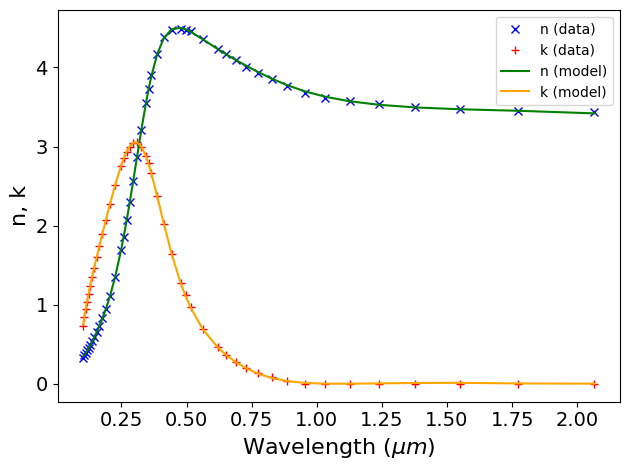

In [4]:
# ============================================================
#                     MATERIALS                    
# ============================================================

#---------------------------<< Substrate Material >>------------------------------------
n_SiO2 = 1.45 # Refractive index
SiO2 = td.Medium(permittivity=n_SiO2**2)

#---------------------------<< Superstrate Material >>------------------------------------
n_sup = 1.0 # Refractive index
Air = td.Medium(permittivity=n_sup**2)

#---------------------------<< Metaatom Material >>------------------------------------
# fitting refractive index data to get a dispersive medium  
url = "https://refractiveindex.info/tmp/database/data-nk/main/Si/Pierce.txt"
fitter = FastDispersionFitter.from_url(url, delimiter="\t")
silicon, error = fitter.fit(max_num_poles=5, tolerance_rms=1e-5)
print("Fit RMS error:", error)
ax = fitter.plot(silicon)
ax.set_title(ax.get_title(), fontsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.tick_params(axis='both', labelsize=14)
plt.show()

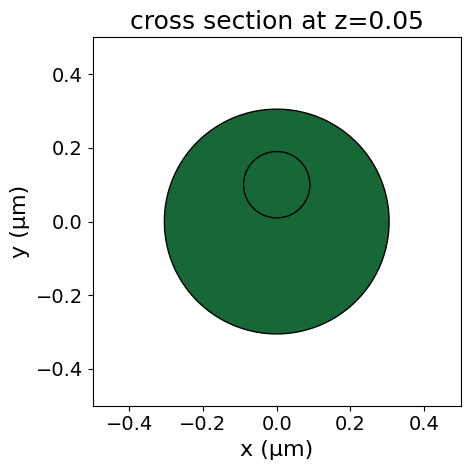

In [16]:
# ============================================================
#                    STRUCTURES                 
# ============================================================

#---------------------------<< Substrate Structure >>------------------------------------
inf_eff = 1e2
substrate = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)),
    medium=SiO2,
)

#---------------------------<< Superstrate Structure >>------------------------------------
# By default, the superstrate is air and infinite, so no need to define it here



#---------------------------<< Metaatom Structure >>------------------------------------
h = 0.1                 # Height of the Meta-Atom
R = 0.305               # Main Radius          
rh = 0.09               # Hole Radius               
delta=0.1               # Off-Center Hole              
px = py = 1             # Meta-Atom Periodicity              
alpha = np.deg2rad(0)   # Meta-Atom Rotation
x0_1, y0_1 = 0, 0       # Si Main Cylinder Location
x0_2, y0_2 = 0, delta   # Off-Center Air Hole Location
n = 500                 # Number of Points

def Meta_atom(x0, y0, Rs, n):
    vertices = []
    dtheta = 2.0 * np.pi / n
    for i in range(n):
        theta = i * dtheta
        Xp = (Rs) * np.cos(theta)
        Yp = (Rs) * np.sin(theta)
        x = x0 + Xp
        y = y0 + Yp
        vertices.append((x, y))
    return vertices

nanodisk_1 = td.Structure(
    geometry=td.PolySlab(
        vertices=Meta_atom(x0_1, y0_1, R, n), axis=2, slab_bounds=(0, h)
    ),
    medium=silicon,
)

nanodisk_2 = td.Structure(
    geometry=td.PolySlab(
        vertices=Meta_atom(x0_2, y0_2, rh, n), axis=2, slab_bounds=(0, h)
    ),
    medium=Air,
)

# Plot the Meta Atom shape 
ax = nanodisk_1.plot(z=0.5*h)
nanodisk_2.plot(z=0.5*h, ax=ax)
ax.set_xlim(-px / 2, px / 2)
ax.set_ylim(-py / 2, py / 2)
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
ax.set_aspect("equal", adjustable="box")
ax.set_title(ax.get_title(), fontsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.tick_params(axis='both', labelsize=14)
plt.show()

# ============================================================
#                    FINITE METASURFACE              
# ============================================================
Nx = 50     # Number of Meta-Atoms in the x direction
Ny = 50     # Number of Meta-Atoms in the y direction

metasurface = [substrate]

for i in range(Nx):
    for j in range(Ny):
        # Shift positions
        x_shift = i * px
        y_shift = j * py

        # Silicon base (main disk)
        disk = td.Structure(
            geometry=td.PolySlab(
                vertices=[(x + x_shift, y + y_shift) for x, y in Meta_atom(0, 0, R, n)],
                axis=2,
                slab_bounds=(0, h),
            ),
            medium=silicon,
        )

        # Air hole
        hole = td.Structure(
            geometry=td.PolySlab(
                vertices=[(x + x_shift, y + y_shift) for x, y in Meta_atom(0, delta, rh, n)],
                axis=2,
                slab_bounds=(0, h),
            ),
            medium=Air,
        )

        metasurface.extend([disk, hole])

### Source and Monitors

In [ ]:
# ============================================================
#                    SOURCES             
# ============================================================


In [ ]:

#------------<< Gets the current working directory (the folder where your notebook is running) >>----------
cwd = Path.cwd()
candidates = [
    cwd / "amorphous_silicon_from_paper.txt",  
    cwd / "amorphous_silicon_from_paper",       
    cwd / "misc" / "amorphous_silicon_from_paper.txt",
    cwd / "misc" / "amorphous_silicon_from_paper",
]

fname = next((p for p in candidates if p.exists()), None)

if fname is not None:
    print(f"Found it From Your Ellipsometery: {fname}")
    fitter = FastDispersionFitter.from_file(str(fname))
else:
    print("Local file not found, loading from refractiveindex.info instead...")
    url = "https://refractiveindex.info/tmp/database/data-nk/main/Si/Pierce.txt"
    fitter = FastDispersionFitter.from_url(url, delimiter="\t")
#------------------------------------------<< Fit the Data and Plot it >>-------------------------------------------
silicon, error = fitter.fit(max_num_poles=5, tolerance_rms=1e-5)
print("Fit RMS error:", error)
ax = fitter.plot(silicon)
ax.set_title(ax.get_title(), fontsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.tick_params(axis='both', labelsize=14)
plt.show()

In [7]:
print(sim_params["freqs"])

[1.94670427e+14 1.94696042e+14 1.94721656e+14 1.94747271e+14
 1.94772885e+14 1.94798500e+14 1.94824114e+14 1.94849729e+14
 1.94875344e+14 1.94900958e+14 1.94926573e+14 1.94952187e+14
 1.94977802e+14 1.95003416e+14 1.95029031e+14 1.95054645e+14
 1.95080260e+14 1.95105874e+14 1.95131489e+14 1.95157103e+14
 1.95182718e+14 1.95208332e+14 1.95233947e+14 1.95259561e+14
 1.95285176e+14 1.95310791e+14 1.95336405e+14 1.95362020e+14
 1.95387634e+14 1.95413249e+14 1.95438863e+14 1.95464478e+14
 1.95490092e+14 1.95515707e+14 1.95541321e+14 1.95566936e+14
 1.95592550e+14 1.95618165e+14 1.95643779e+14 1.95669394e+14
 1.95695008e+14 1.95720623e+14 1.95746238e+14 1.95771852e+14
 1.95797467e+14 1.95823081e+14 1.95848696e+14 1.95874310e+14
 1.95899925e+14 1.95925539e+14 1.95951154e+14 1.95976768e+14
 1.96002383e+14 1.96027997e+14 1.96053612e+14 1.96079226e+14
 1.96104841e+14 1.96130455e+14 1.96156070e+14 1.96181685e+14
 1.96207299e+14 1.96232914e+14 1.96258528e+14 1.96284143e+14
 1.96309757e+14 1.963353

In [ ]:
# Define computational Domain Size
#--------------------------<< Number of Meta-Atoms in the x direction >>----------------------------------------
Nx = 50
#--------------------------<< Number of Meta-Atoms in the y direction >>----------------------------------------
Ny = 50
#-----------------------------------<< Choosing the Wavelength >>-----------------------------------------------
lambda_sel_um = 1.5325
idx = int(np.argmin(np.abs(wavelengths - lambda_sel_um)))
lambda_used_um = float(wavelengths[idx])
f_sel = float(freqs[idx])
print(f"Plotting field at λ ≈ {lambda_used_um:.4f} µm  (f ≈ {f_sel/1e12:.3f} THz)")
#-----------------------------<< Buffer Spacing in the x and y Directions >>------------------------------------
buffer = 2 * lambda_used_um
#-----------------------------------<< Simulation Domain Size >>-----------------------------------------------
Lx, Ly, Lz = Nx*px+2*buffer,Ny*py+2 * buffer, 3 * lambda_used_um
sim_size = [Lx, Ly, Lz]

                TIDY3D SIMULATION STEPS            
>>> INITIALIZATION <<<
0. Define wavelength or frequency range [sim_params = define_simulation_parameters(wvl_min=, wvl_max=, Nfreq=, Mesh=32, run_factor=200)]
1. Define computational domain size
2. Define grid specifications (discretization size)
3. Define structures (geometry, materials, etc.)
4. Define sources (plane wave, Gaussian beam, etc.)
5. Define monitors (fields, flux, etc.)
6. Set simulation run time
7. Specify boundary conditions

>>> SIMULATION <<<
• Assign simulation object (loop or single instance)
• Run simulation (locally or via cloud)

>>> FINALIZATION <<<
• Retrieve results
• Perform postprocessing (e.g., transmission, phase, efficiency)
• Save data to JSON/HDF5/plots

               END OF SIMULATION STEPS             


# Material Properties

Output()

Found it From Your Ellipsometery: C:\Users\Hooman\PyCharmMiscProject\amorphous_silicon_from_paper.txt


19:34:34 Eastern Daylight Time WARNING: Unable to fit with weighted RMS error   
                               under 'tolerance_rms' of 1e-05                   

Fit RMS error: 0.11616714602733227


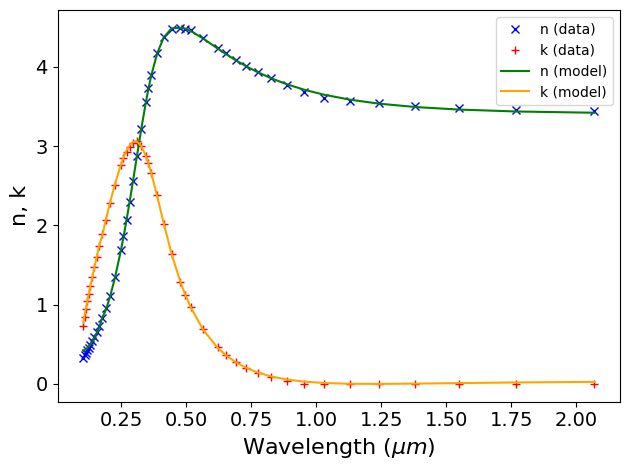

In [56]:
#------<< a Python tool for working with file and folder paths safely across operating systems >>---------
from pathlib import Path
from tidy3d.plugins.dispersion import FastDispersionFitter
#---------------------------<< Refractive index of the  substrate >>--------------------------------------
n_SiO2 = 1.45
SiO2 = td.Medium(permittivity=n_SiO2**2)
#---------------------------<< Refractive index of the  superstrate >>------------------------------------
n_sup = 1.0
Air = td.Medium(permittivity=n_sup**2)
#------------<< Gets the current working directory (the folder where your notebook is running) >>----------
cwd = Path.cwd()
candidates = [
    cwd / "amorphous_silicon_from_paper.txt",  
    cwd / "amorphous_silicon_from_paper",       
    cwd / "misc" / "amorphous_silicon_from_paper.txt",
    cwd / "misc" / "amorphous_silicon_from_paper",
]

fname = next((p for p in candidates if p.exists()), None)

if fname is not None:
    print(f"Found it From Your Ellipsometery: {fname}")
    fitter = FastDispersionFitter.from_file(str(fname))
else:
    print("Local file not found, loading from refractiveindex.info instead...")
    url = "https://refractiveindex.info/tmp/database/data-nk/main/Si/Pierce.txt"
    fitter = FastDispersionFitter.from_url(url, delimiter="\t")
#------------------------------------------<< Fit the Data and Plot it >>-------------------------------------------
silicon, error = fitter.fit(max_num_poles=5, tolerance_rms=1e-5)
print("Fit RMS error:", error)
ax = fitter.plot(silicon)
ax.set_title(ax.get_title(), fontsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.tick_params(axis='both', labelsize=14)
plt.show()

# Geometry of the Meta-Atoms

In [57]:
#------------------<< Height of the Meta-Atom >>------------------
h = 0.1      
#------------------------<< Main Radius >>------------------------
R = 0.305                
#------------------------<< Hole Radius >>------------------------
rh = 0.09                 
#----------------------<< Off-Center Hole >>----------------------
delta=0.1                 
#--------------------<< Meta-Atom Periodicity >>------------------
px = 1                   
py = 1     
#--------------------<< Meta-Atom Rotation >>---------------------
alpha = np.deg2rad(0)

# Simulation Setup:
## 1. Setting Up Monitors

In [58]:
def Meta_atom(x0, y0, Rs, n):

    vertices = []
    dtheta = 2.0 * np.pi / n

    for i in range(n):
        theta = i * dtheta
        Xp = (Rs) * np.cos(theta)
        Yp = (Rs) * np.sin(theta)
        x = x0 + Xp
        y = y0 + Yp
        vertices.append((x, y))

    return vertices

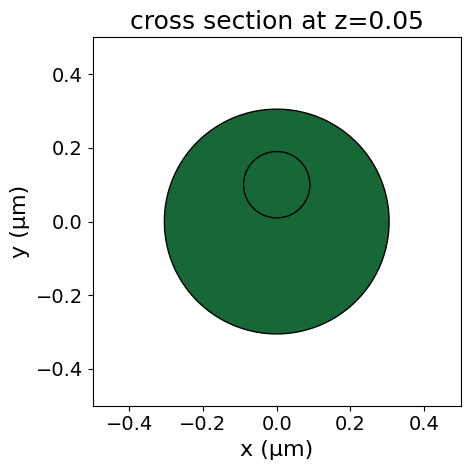

In [59]:
#--------------------------<< Si Main Cylinder >>--------------------------------
x0_1 = 0
y0_1 = 0
#--------------------------<< Air Main Cylinder >>--------------------------------
x0_2 = 0
y0_2 = delta
#--------------------------<< Number of Points >>----------------------------------
n = 500
#--------------------------<< Geometry Topology  >>--------------------------------
nanodisk_1 = td.Structure(
    geometry=td.PolySlab(
        vertices=Meta_atom(x0_1, y0_1, R, n), axis=2, slab_bounds=(0, h)
    ),
    medium=silicon,
)
nanodisk_2 = td.Structure(
    geometry=td.PolySlab(
        vertices=Meta_atom(x0_2, y0_2, rh, n), axis=2, slab_bounds=(0, h)
    ),
    medium=Air,
)
#-----------------------<< Create the substrate structure>>-------------------------------
inf_eff = 1e2
substrate = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)),
    medium=SiO2,
)
#--------------------------<< Plot the Meta Atom shape  >>--------------------------------
ax = nanodisk_1.plot(z=0.5*h)
nanodisk_2.plot(z=0.5*h, ax=ax)
ax.set_xlim(-px / 2, px / 2)
ax.set_ylim(-py / 2, py / 2)
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
ax.set_aspect("equal", adjustable="box")
ax.set_title(ax.get_title(), fontsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.tick_params(axis='both', labelsize=14)
plt.show()

In [60]:
#------------------------- << simulation domain size in z >>------------------------------
Lz = 3*lam2
#------------------------------ << Monitor z position >>----------------------------------
monitor_z =Lz/2.5
#----------------------- << Define Transmission Flux Monitor>>----------------------------
T_Monitor = td.FluxMonitor(
    center=[0, 0, -monitor_z], size=[td.inf, td.inf, 0], freqs=freqs, name="T"
)
#---------------- << Define Reflection Flux Monitor: Can be Changed >>--------------------
R_Monitor = td.FluxMonitor(
    center=[0, 0, monitor_z], size=[td.inf, td.inf, 0], freqs=freqs, name="R"
)

# Finite Metasurface

Plotting field at λ ≈ 1.5324 µm  (f ≈ 195.636 THz)


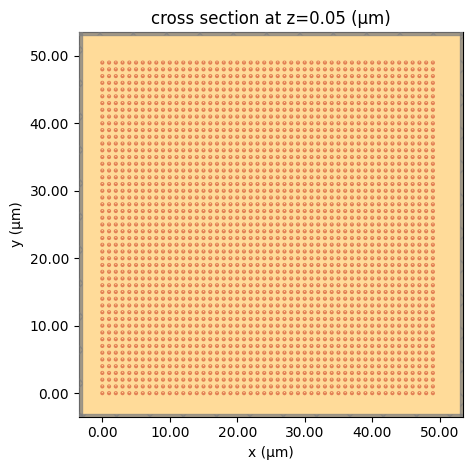

In [61]:
#--------------------------<< Number of Meta-Atoms in the x direction >>----------------------------------------
Nx = 50
#--------------------------<< Number of Meta-Atoms in the y direction >>----------------------------------------
Ny = 50
#-----------------------------------<< Choosing the Wavelength >>-----------------------------------------------
lambda_sel_um = 1.5325
idx = int(np.argmin(np.abs(wavelengths - lambda_sel_um)))
lambda_used_um = float(wavelengths[idx])
f_sel = float(freqs[idx])
print(f"Plotting field at λ ≈ {lambda_used_um:.4f} µm  (f ≈ {f_sel/1e12:.3f} THz)")
#-----------------------------<< Buffer Spacing in the x and y Directions >>------------------------------------
buffer = 2 * lambda_used_um
#-----------------------------------<< Simulation Domain Size >>-----------------------------------------------
Lx, Ly, Lz = Nx*px+2*buffer,Ny*py+2 * buffer, 3 * lambda_used_um
sim_size = [Lx, Ly, Lz]
# systematically construct the silicon resonators
metasurface = [substrate]

for i in range(Nx):
    for j in range(Ny):
        cylinder = td.Structure(
            geometry=td.Cylinder(center=[i * px, j * py, h / 2], radius=R, length=h, axis=2),
            medium=silicon,
        )
        metasurface.append(cylinder)

for i in range(Nx):
    for j in range(Ny):
        cylinder = td.Structure(
            geometry=td.Cylinder(center=[i * px, delta+(j * py), h / 2], radius=rh, length=h, axis=2),
            medium=Air,
        )
        metasurface.append(cylinder)

gaussian = td.GaussianBeam(
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=f_sel, fwidth=0.5 * freqw),
    center=(px * (Nx // 2), py * (Ny // 2), lambda_used_um),
    direction="-",
    waist_radius=10* lambda_used_um,
)

# define a field monitor to visualize the field distribution under gaussian beam excitation
monitor_field = td.FieldMonitor(
    center=[0, 0, h/2], size=[td.inf, td.inf, 0], freqs=[f_sel], name="field"
)

sim = td.Simulation(
    size=sim_size,
    center=(px * (Nx // 2), py * (Ny // 2), 0),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=Mesh, wavelength= lambda_used_um),
    structures=metasurface,
    sources=[gaussian],
    monitors=[T_Monitor,R_Monitor,monitor_field],  # we will reuse the flux monitors defined earlier
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),  # pml is applied in all boundaries
    symmetry=(0, 0, 0),
)

sim.plot(z=h/2)
plt.show()
sim.plot_3d()

In [62]:
sim_data = web.run(
    sim,
    task_name="Finite_Metasurface",
    path="data/simulation.hdf5",
    verbose=True,
)

19:34:45 Eastern Daylight Time Created task 'Finite_Metasurface' with task_id   
                               'fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=814260;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=257087;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\taskId]8;;\
                               ]8;id=814260;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\=]8;;\]8;id=237111;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\fdve]8;;\]8;id=814260;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\-d5684ce6-ee6e-42a5-af7b-3c43750a74ac']8;;\.

                               Task folder: ]8;id=609795;https://tidy3d.simulation.cloud/folders/folder-a490576e-3e8b-4f7b-a2bc-dc9c69c79bac\'default']8;;\.

Output()

19:35:03 Eastern Daylight Time Maximum FlexCredit cost: 46.452. Minimum cost    
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

19:35:04 Eastern Daylight Time status = queued

                               To cancel the simulation, use                    
                               'web.abort(task_id)' or 'web.delete(task_id)' or 
                               abort/delete the task in the web UI. Terminating 
                               the Python script will not stop the job running  
                               on the cloud.

Output()

19:35:17 Eastern Daylight Time status = preprocess

19:35:51 Eastern Daylight Time starting up solver

                               running solver

Output()

19:42:35 Eastern Daylight Time early shutoff detected at 48%, exiting.

                               status = postprocess

Output()

19:42:56 Eastern Daylight Time status = success

19:42:58 Eastern Daylight Time View simulation result at                        
                               ]8;id=448173;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=732387;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\taskId]8;;\
                               ]8;id=448173;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\=]8;;\]8;id=38147;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\fdve]8;;\]8;id=448173;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\-d5684ce6-ee6e-42a5-af7b-3c43750a74ac']8;;\.

Output()

19:44:03 Eastern Daylight Time loading simulation from data/simulation.hdf5

In [63]:
# web.real_cost("all_dielectric_metasurface_absorber")

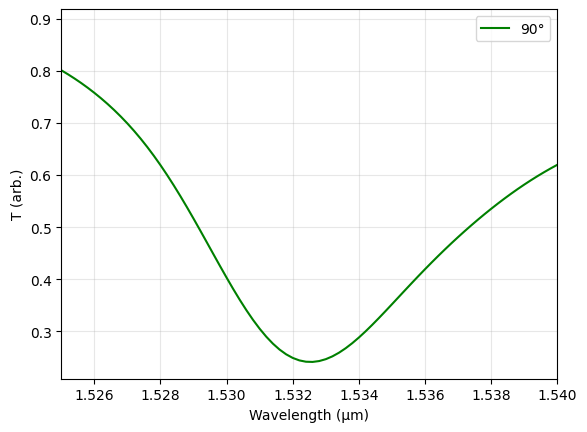

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td

R = sim_data["R"].flux
T = -sim_data["T"].flux  # if you really want the negative

# convert freq→wavelength (µm)
wavelengths_um = (td.C_0 / T.f.values)
Tvals = T.values

# sort so wavelength increases left→right
idx = np.argsort(wavelengths_um)
wavelengths_um = wavelengths_um[idx]
Tvals = Tvals[idx]

plt.plot(wavelengths_um, Tvals, color="green", label="90°")
plt.xlim(1.525, 1.54)           # <-- zoom window in µm
plt.xlabel("Wavelength (µm)")
plt.ylabel("T (arb.)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


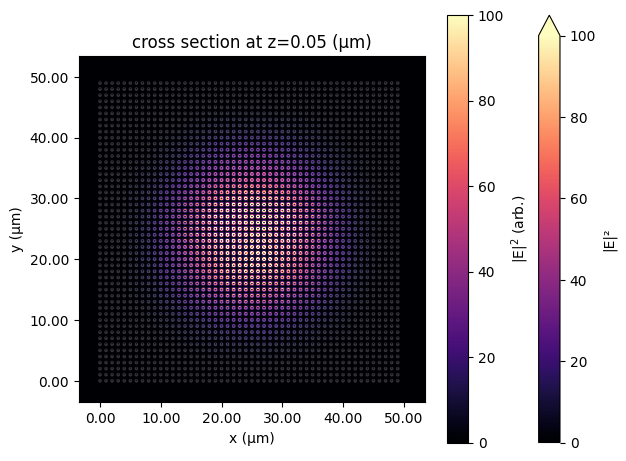

In [75]:
import matplotlib.pyplot as plt

# --- your knobs ---
vmin, vmax   = 0, 100            # manual color limits
cmap_name    = "magma"         # try: "magma", "turbo", "viridis", "cividis", "plasma", "RdBu_r"

ax = sim_data.plot_field(
    field_monitor_name="field",
    field_name="E",
    val="abs^2",
    vmin=vmin,
    vmax=vmax,
    shading="auto",
)

# grab the QuadMesh that carries the image and set the colormap
qm = next(c for c in ax.collections if hasattr(c, "get_array"))
qm.set_cmap(cmap_name)

# colorbar
plt.colorbar(qm, ax=ax, label=r"|E|$^2$ (arb.)")
plt.show()
